In [ ]:
!pip install optuna

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,KFold
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import math
import torch.nn.functional as F
import re
import optuna
from optuna.trial import TrialState
from torch.optim import Adam
import torch.nn.functional as F

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/data.csv')

In [4]:
df.shape

(134281, 4)

In [5]:
df.sample(5)

,pep,logic,allele,mhc
127991,SYKICTDKMFFVKNP,0.521603,DRB1_1301,QEFFIASGAAVDAIMESSFDYFDIDEATYHVVFT
6300,EPTAAPAEPEAPAPE,0.430975,HLA-DQA10301-DQB10302,YNYHERRFATVLHIVYFGLTYYAVRTETVHLETT
41004,YDKFLENVSTVLTGK,0.549817,DRB1_0401,QEFFIASGAAVDAIMEVHFDYYDLQKATYHVGFT
18371,EAVSLLCSDKQPCNG,0.039747,DRB1_0901,QEFFIASGAAVDAIMKDFYHGYVFRRETVHVGFT
102409,RFYKTLRAEQAS,0.383350,DRB1_1101,QEFFIASGAAVDAIMESSFDYFDFDRATYHVGFT


In [ ]:
df.isnull().sum()

,0
pep,0
logic,0
allele,0
mhc,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134281 entries, 0 to 134280
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   pep     134281 non-null  object 
 1   logic   134281 non-null  float64
 2   allele  134281 non-null  object 
 3   mhc     134281 non-null  object 
dtypes: float64(1), object(3)
memory usage: 4.1+ MB


In [6]:
df.drop(columns=['allele'],inplace=True)
df.sample(5)

,pep,logic,mhc
30246,ATVATAPEVKYTVFE,0.152382,YMFFMFSGGAISNTLFGQFEYFDIEKVRMHLGMT
89033,AYGSFVRTVSLPVGA,0.230868,CNYHEGGGARVAHIMYFGGTHYVVGASRVHVAGI
19856,MVFTPLLALATNLTE,0.712301,QEFFIASGAAVDAIMESSFDYFDFDRATYHVGFT
123165,VCGMFTNRSGSQQ,0.390562,QEFFIASGAAVDAIMWGYFELYVIDRQTVHVGFT
12272,VRKNRWLLLNVTSED,0.430172,QEFFIASGAAVDAIMESSYDYFDLQKRNYHVVFT


In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [8]:
threshold = 0.4256

scoredf = df['logic'].apply(lambda x: 1 if x > threshold else 0)

In [9]:
scoredf.value_counts()

,count
logic,
0,78308
1,55973


In [10]:
y = torch.tensor(scoredf.values,dtype=torch.float32)

In [11]:
pep_embeddings = torch.tensor(np.load('/content/drive/MyDrive/tensor_data_pep_cls.npy'))

In [12]:
file_path = '/content/drive/MyDrive/tensor_data_mhc_cls.npy'
mhc_embeddings = torch.tensor(np.load(file_path))

In [ ]:
X = torch.stack((pep_embeddings,mhc_embeddings),dim=1)
y = scores

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)

In [ ]:
train_dataset = TensorDataset(X_train[: ,0],X_train[:,1], y_train)
val_dataset = TensorDataset(X_val[:,0],X_val[:,1], y_val)


In [23]:
test_dataset = TensorDataset(X_test[:,0],X_test[:,1],y_test)

In [24]:
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [20]:
class TransformerEncoder(nn.Module):
    def __init__(self, model_dim, num_heads, num_layers, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim, nhead=num_heads, dropout=dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)

    def forward(self, x):
        return self.transformer_encoder(x)


class CrossAttentionLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super(CrossAttentionLayer, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, embed_dim),
            nn.Dropout(dropout),
        )
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, query, key, value):
        attn_output, _ = self.multihead_attn(query, key, value)
        attn_output = self.norm1(attn_output + query)
        ffn_output = self.ffn(attn_output)
        output = self.norm2(ffn_output + attn_output)

        return output


class SequenceModel(nn.Module):
    def __init__(self, model_dim, num_heads, num_layers, ffdim, dropout=0.1):
        super(SequenceModel, self).__init__()
        self.encoder_pep = TransformerEncoder(model_dim, num_heads, num_layers, dropout)
        self.encoder_mhc = TransformerEncoder(model_dim, num_heads, num_layers, dropout)
        self.cross_attention = CrossAttentionLayer(model_dim, num_heads, ffdim, dropout)
        self.fc1 = nn.Linear(model_dim, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 1)

        self.dropout = nn.Dropout(dropout)

    def forward(self, pep_cls, mhc_cls):
        pep_refined = self.encoder_pep(pep_cls.unsqueeze(1)).squeeze(1)
        mhc_refined = self.encoder_mhc(mhc_cls.unsqueeze(1)).squeeze(1)
        cross_output = self.cross_attention(pep_refined.unsqueeze(1), mhc_refined.unsqueeze(1), mhc_refined.unsqueeze(1))
        cross_output = cross_output.squeeze(1)
        x = F.relu(self.fc1(cross_output))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [ ]:
torch.manual_seed(3407)

In [ ]:
def objective(trial):
    #hyperparamas
    model_dim = 320
    num_heads = trial.suggest_categorical("num_heads", [4, 8])
    num_layers = trial.suggest_categorical("num_layers", [2, 3, 4])
    dropout = trial.suggest_categorical("dropout", [0.1, 0.2, 0.3])
    ffdim = trial.suggest_categorical("ffdim", [256, 512])
    lr = trial.suggest_categorical("learning_rate", [1e-4, 5e-4, 1e-3])
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256])

    #model init
    model = SequenceModel(
        model_dim=model_dim,
        num_heads=num_heads,
        num_layers=num_layers,
        ffdim=ffdim,
        dropout=dropout
    ).to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(5):

        model.train()
        for pep_ids, mhc_ids, scores in train_loader:
            pep_ids, mhc_ids, scores = pep_ids.to(device), mhc_ids.to(device), scores.to(device)
            optimizer.zero_grad()
            outputs = model(pep_ids, mhc_ids).squeeze()

            loss = criterion(outputs, scores)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        total_preds, total_labels = [], []
        with torch.no_grad():
            for pep_ids, mhc_ids, scores in val_loader:
                pep_ids, mhc_ids, scores = pep_ids.to(device), mhc_ids.to(device), scores.to(device)
                outputs = model(pep_ids, mhc_ids).squeeze()
                loss = criterion(outputs, scores)
                val_loss += loss.item()

                probs = torch.sigmoid(outputs).cpu()
                total_preds.append(probs)
                total_labels.append(scores.cpu())

        val_loss /= len(val_loader)

        total_preds = torch.cat(total_preds).numpy()
        total_labels = torch.cat(total_labels).numpy()

        binary_preds = (total_preds > 0.4256).astype(int)

        val_precision = precision_score(total_labels, binary_preds)
        val_recall = recall_score(total_labels, binary_preds)
        val_f1 = f1_score(total_labels, binary_preds)

        val_auroc = roc_auc_score(total_labels, total_preds)

        print(f"Trial Results: Val Loss: {val_loss:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}, AUROC: {val_auroc:.4f}")

    return val_loss


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

print("Best trial:")
trial = study.best_trial
print(f"  Val Loss: {trial.value:.4f}")
print(f"  Hyperparameters: {trial.params}")


[I 2025-02-04 10:43:21,352] A new study created in memory with name: no-name-1cca244a-781f-497f-9df3-4870f992b9a1


Trial Results: Val Loss: 0.6245, Precision: 0.5695, Recall: 0.6812, F1 Score: 0.6203, AUROC: 0.6963
Trial Results: Val Loss: 0.6189, Precision: 0.5590, Recall: 0.7326, F1 Score: 0.6342, AUROC: 0.6986
Trial Results: Val Loss: 0.6165, Precision: 0.5604, Recall: 0.7406, F1 Score: 0.6380, AUROC: 0.6999
Trial Results: Val Loss: 0.6167, Precision: 0.5666, Recall: 0.7204, F1 Score: 0.6343, AUROC: 0.7010


[I 2025-02-04 10:44:15,623] Trial 0 finished with value: 0.6208582307611193 and parameters: {'num_heads': 4, 'num_layers': 2, 'dropout': 0.2, 'ffdim': 256, 'learning_rate': 0.001, 'weight_decay': 0.0010824412769400316, 'batch_size': 128}. Best is trial 0 with value: 0.6208582307611193.


Trial Results: Val Loss: 0.6209, Precision: 0.5310, Recall: 0.8268, F1 Score: 0.6466, AUROC: 0.7067
Trial Results: Val Loss: 0.6342, Precision: 0.6139, Recall: 0.4669, F1 Score: 0.5304, AUROC: 0.7057
Trial Results: Val Loss: 0.6213, Precision: 0.5257, Recall: 0.8310, F1 Score: 0.6440, AUROC: 0.7124
Trial Results: Val Loss: 0.6061, Precision: 0.5585, Recall: 0.7517, F1 Score: 0.6409, AUROC: 0.7192
Trial Results: Val Loss: 0.6051, Precision: 0.5533, Recall: 0.7795, F1 Score: 0.6472, AUROC: 0.7201


[I 2025-02-04 10:45:00,537] Trial 1 finished with value: 0.6157769915603456 and parameters: {'num_heads': 8, 'num_layers': 3, 'dropout': 0.1, 'ffdim': 512, 'learning_rate': 0.001, 'weight_decay': 0.0009121862739674533, 'batch_size': 256}. Best is trial 1 with value: 0.6157769915603456.


Trial Results: Val Loss: 0.6158, Precision: 0.6030, Recall: 0.5647, F1 Score: 0.5832, AUROC: 0.7193
Trial Results: Val Loss: 0.5814, Precision: 0.6249, Recall: 0.6613, F1 Score: 0.6426, AUROC: 0.7515
Trial Results: Val Loss: 0.5616, Precision: 0.6303, Recall: 0.6809, F1 Score: 0.6546, AUROC: 0.7700
Trial Results: Val Loss: 0.5612, Precision: 0.6122, Recall: 0.7321, F1 Score: 0.6668, AUROC: 0.7732
Trial Results: Val Loss: 0.5617, Precision: 0.6654, Recall: 0.6235, F1 Score: 0.6438, AUROC: 0.7770


[I 2025-02-04 10:45:31,098] Trial 2 finished with value: 0.5475142906819072 and parameters: {'num_heads': 4, 'num_layers': 2, 'dropout': 0.2, 'ffdim': 512, 'learning_rate': 0.0001, 'weight_decay': 0.0005219032898403999, 'batch_size': 256}. Best is trial 2 with value: 0.5475142906819072.


Trial Results: Val Loss: 0.5475, Precision: 0.6557, Recall: 0.6723, F1 Score: 0.6639, AUROC: 0.7831
Trial Results: Val Loss: 0.6814, Precision: 0.4229, Recall: 1.0000, F1 Score: 0.5945, AUROC: 0.4965


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Trial Results: Val Loss: 0.6812, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, AUROC: 0.6075


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Trial Results: Val Loss: 0.6830, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, AUROC: 0.5149


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Trial Results: Val Loss: 0.6812, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, AUROC: 0.5169


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2025-02-04 10:47:53,923] Trial 3 finished with value: 0.6812562169063658 and parameters: {'num_heads': 8, 'num_layers': 3, 'dropout': 0.2, 'ffdim': 512, 'learning_rate': 0.001, 'weight_decay': 1.4304859979568765e-05, 'batch_size': 64}. Best is trial 2 with value: 0.5475142906819072.


Trial Results: Val Loss: 0.6813, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, AUROC: 0.5184
Trial Results: Val Loss: 0.6434, Precision: 0.4973, Recall: 0.8972, F1 Score: 0.6399, AUROC: 0.6945
Trial Results: Val Loss: 0.6275, Precision: 0.5258, Recall: 0.8256, F1 Score: 0.6424, AUROC: 0.6961
Trial Results: Val Loss: 0.6234, Precision: 0.5336, Recall: 0.8123, F1 Score: 0.6441, AUROC: 0.6997
Trial Results: Val Loss: 0.6188, Precision: 0.5725, Recall: 0.6729, F1 Score: 0.6186, AUROC: 0.6999


[I 2025-02-04 10:49:07,344] Trial 4 finished with value: 0.6180809622719174 and parameters: {'num_heads': 8, 'num_layers': 3, 'dropout': 0.3, 'ffdim': 512, 'learning_rate': 0.001, 'weight_decay': 0.0020322654703058894, 'batch_size': 128}. Best is trial 2 with value: 0.5475142906819072.


Trial Results: Val Loss: 0.6181, Precision: 0.5473, Recall: 0.7855, F1 Score: 0.6451, AUROC: 0.7029
Trial Results: Val Loss: 0.5814, Precision: 0.6232, Recall: 0.6675, F1 Score: 0.6446, AUROC: 0.7537
Trial Results: Val Loss: 0.5741, Precision: 0.6069, Recall: 0.7217, F1 Score: 0.6593, AUROC: 0.7649
Trial Results: Val Loss: 0.5848, Precision: 0.5716, Recall: 0.7734, F1 Score: 0.6573, AUROC: 0.7567
Trial Results: Val Loss: 0.5714, Precision: 0.6453, Recall: 0.6259, F1 Score: 0.6355, AUROC: 0.7645


[I 2025-02-04 10:53:47,470] Trial 5 finished with value: 0.5629576052583399 and parameters: {'num_heads': 8, 'num_layers': 3, 'dropout': 0.1, 'ffdim': 256, 'learning_rate': 0.0001, 'weight_decay': 0.0007129316793598172, 'batch_size': 32}. Best is trial 2 with value: 0.5475142906819072.


Trial Results: Val Loss: 0.5630, Precision: 0.6617, Recall: 0.6299, F1 Score: 0.6454, AUROC: 0.7733
Trial Results: Val Loss: 0.6398, Precision: 0.5171, Recall: 0.8055, F1 Score: 0.6299, AUROC: 0.6836
Trial Results: Val Loss: 0.6299, Precision: 0.5893, Recall: 0.5755, F1 Score: 0.5823, AUROC: 0.6930
Trial Results: Val Loss: 0.6278, Precision: 0.5900, Recall: 0.5750, F1 Score: 0.5824, AUROC: 0.6956
Trial Results: Val Loss: 0.6201, Precision: 0.5625, Recall: 0.7218, F1 Score: 0.6323, AUROC: 0.6933


[I 2025-02-04 10:55:19,675] Trial 6 finished with value: 0.6253380239719436 and parameters: {'num_heads': 4, 'num_layers': 4, 'dropout': 0.1, 'ffdim': 256, 'learning_rate': 0.001, 'weight_decay': 0.009615756449233256, 'batch_size': 128}. Best is trial 2 with value: 0.5475142906819072.


Trial Results: Val Loss: 0.6253, Precision: 0.5897, Recall: 0.5886, F1 Score: 0.5892, AUROC: 0.6971
Trial Results: Val Loss: 0.5968, Precision: 0.6449, Recall: 0.5577, F1 Score: 0.5981, AUROC: 0.7364
Trial Results: Val Loss: 0.5762, Precision: 0.6261, Recall: 0.6591, F1 Score: 0.6421, AUROC: 0.7563
Trial Results: Val Loss: 0.5780, Precision: 0.6293, Recall: 0.6542, F1 Score: 0.6415, AUROC: 0.7563
Trial Results: Val Loss: 0.5701, Precision: 0.6700, Recall: 0.6037, F1 Score: 0.6351, AUROC: 0.7692


[I 2025-02-04 10:58:45,195] Trial 7 finished with value: 0.5605837679689839 and parameters: {'num_heads': 8, 'num_layers': 4, 'dropout': 0.3, 'ffdim': 256, 'learning_rate': 0.0001, 'weight_decay': 1.225532422954887e-05, 'batch_size': 64}. Best is trial 2 with value: 0.5475142906819072.


Trial Results: Val Loss: 0.5606, Precision: 0.6839, Recall: 0.5864, F1 Score: 0.6314, AUROC: 0.7747
Trial Results: Val Loss: 0.6812, Precision: 0.4229, Recall: 1.0000, F1 Score: 0.5945, AUROC: 0.6481
Trial Results: Val Loss: 0.6246, Precision: 0.5472, Recall: 0.7542, F1 Score: 0.6342, AUROC: 0.6913
Trial Results: Val Loss: 0.6156, Precision: 0.5338, Recall: 0.8062, F1 Score: 0.6423, AUROC: 0.7111
Trial Results: Val Loss: 0.6120, Precision: 0.5459, Recall: 0.7852, F1 Score: 0.6440, AUROC: 0.7187


[I 2025-02-04 11:00:30,151] Trial 8 finished with value: 0.6036310100129673 and parameters: {'num_heads': 4, 'num_layers': 2, 'dropout': 0.1, 'ffdim': 256, 'learning_rate': 0.001, 'weight_decay': 3.7561471320220043e-05, 'batch_size': 64}. Best is trial 2 with value: 0.5475142906819072.


Trial Results: Val Loss: 0.6036, Precision: 0.5884, Recall: 0.6399, F1 Score: 0.6131, AUROC: 0.7238
Trial Results: Val Loss: 0.5899, Precision: 0.5902, Recall: 0.7415, F1 Score: 0.6572, AUROC: 0.7512
Trial Results: Val Loss: 0.5723, Precision: 0.6628, Recall: 0.5907, F1 Score: 0.6247, AUROC: 0.7654
Trial Results: Val Loss: 0.5604, Precision: 0.6422, Recall: 0.6634, F1 Score: 0.6526, AUROC: 0.7707
Trial Results: Val Loss: 0.5578, Precision: 0.6571, Recall: 0.6420, F1 Score: 0.6495, AUROC: 0.7750


[I 2025-02-04 11:01:59,767] Trial 9 finished with value: 0.5531045342130321 and parameters: {'num_heads': 4, 'num_layers': 4, 'dropout': 0.2, 'ffdim': 512, 'learning_rate': 0.0001, 'weight_decay': 0.0006412073622637559, 'batch_size': 128}. Best is trial 2 with value: 0.5475142906819072.


Trial Results: Val Loss: 0.5531, Precision: 0.6540, Recall: 0.6619, F1 Score: 0.6580, AUROC: 0.7776
Trial Results: Val Loss: 0.6026, Precision: 0.6345, Recall: 0.5717, F1 Score: 0.6015, AUROC: 0.7320
Trial Results: Val Loss: 0.5818, Precision: 0.6262, Recall: 0.6532, F1 Score: 0.6394, AUROC: 0.7549
Trial Results: Val Loss: 0.5627, Precision: 0.6194, Recall: 0.7061, F1 Score: 0.6599, AUROC: 0.7706
Trial Results: Val Loss: 0.5657, Precision: 0.5932, Recall: 0.7641, F1 Score: 0.6679, AUROC: 0.7702


[I 2025-02-04 11:02:31,857] Trial 10 finished with value: 0.5598493161655608 and parameters: {'num_heads': 4, 'num_layers': 2, 'dropout': 0.2, 'ffdim': 512, 'learning_rate': 0.0005, 'weight_decay': 0.00012726606742723273, 'batch_size': 256}. Best is trial 2 with value: 0.5475142906819072.


Trial Results: Val Loss: 0.5598, Precision: 0.6806, Recall: 0.6016, F1 Score: 0.6387, AUROC: 0.7757
Trial Results: Val Loss: 0.6104, Precision: 0.5386, Recall: 0.8170, F1 Score: 0.6492, AUROC: 0.7369
Trial Results: Val Loss: 0.5690, Precision: 0.6045, Recall: 0.7294, F1 Score: 0.6611, AUROC: 0.7668
Trial Results: Val Loss: 0.5660, Precision: 0.5868, Recall: 0.7590, F1 Score: 0.6619, AUROC: 0.7681
Trial Results: Val Loss: 0.5670, Precision: 0.6809, Recall: 0.5939, F1 Score: 0.6345, AUROC: 0.7766


[I 2025-02-04 11:03:23,565] Trial 11 finished with value: 0.5459519532464799 and parameters: {'num_heads': 4, 'num_layers': 4, 'dropout': 0.2, 'ffdim': 512, 'learning_rate': 0.0001, 'weight_decay': 0.00018883096161472504, 'batch_size': 256}. Best is trial 11 with value: 0.5459519532464799.


Trial Results: Val Loss: 0.5460, Precision: 0.6519, Recall: 0.6740, F1 Score: 0.6628, AUROC: 0.7834
Trial Results: Val Loss: 0.5799, Precision: 0.6058, Recall: 0.7025, F1 Score: 0.6506, AUROC: 0.7522
Trial Results: Val Loss: 0.5724, Precision: 0.6414, Recall: 0.6452, F1 Score: 0.6433, AUROC: 0.7667
Trial Results: Val Loss: 0.5687, Precision: 0.6807, Recall: 0.5790, F1 Score: 0.6257, AUROC: 0.7726
Trial Results: Val Loss: 0.5501, Precision: 0.6433, Recall: 0.6940, F1 Score: 0.6677, AUROC: 0.7799


[I 2025-02-04 11:04:16,560] Trial 12 finished with value: 0.5474629345394316 and parameters: {'num_heads': 4, 'num_layers': 4, 'dropout': 0.2, 'ffdim': 512, 'learning_rate': 0.0001, 'weight_decay': 0.00014436417457109265, 'batch_size': 256}. Best is trial 11 with value: 0.5459519532464799.


Trial Results: Val Loss: 0.5475, Precision: 0.6908, Recall: 0.6173, F1 Score: 0.6519, AUROC: 0.7857
Trial Results: Val Loss: 0.5824, Precision: 0.5882, Recall: 0.7518, F1 Score: 0.6600, AUROC: 0.7543
Trial Results: Val Loss: 0.5661, Precision: 0.6088, Recall: 0.7269, F1 Score: 0.6626, AUROC: 0.7678
Trial Results: Val Loss: 0.5538, Precision: 0.6546, Recall: 0.6592, F1 Score: 0.6569, AUROC: 0.7783
Trial Results: Val Loss: 0.5533, Precision: 0.6680, Recall: 0.6306, F1 Score: 0.6487, AUROC: 0.7799


[I 2025-02-04 11:05:08,815] Trial 13 finished with value: 0.5415346785670235 and parameters: {'num_heads': 4, 'num_layers': 4, 'dropout': 0.2, 'ffdim': 512, 'learning_rate': 0.0001, 'weight_decay': 0.00014550741821155695, 'batch_size': 256}. Best is trial 13 with value: 0.5415346785670235.


Trial Results: Val Loss: 0.5415, Precision: 0.6405, Recall: 0.7173, F1 Score: 0.6767, AUROC: 0.7890
Trial Results: Val Loss: 0.6132, Precision: 0.5831, Recall: 0.6613, F1 Score: 0.6197, AUROC: 0.7116
Trial Results: Val Loss: 0.5967, Precision: 0.5824, Recall: 0.7030, F1 Score: 0.6370, AUROC: 0.7424
Trial Results: Val Loss: 0.5787, Precision: 0.6682, Recall: 0.5523, F1 Score: 0.6048, AUROC: 0.7504
Trial Results: Val Loss: 0.5802, Precision: 0.6390, Recall: 0.6085, F1 Score: 0.6234, AUROC: 0.7544


[I 2025-02-04 11:06:01,014] Trial 14 finished with value: 0.5702745439041228 and parameters: {'num_heads': 4, 'num_layers': 4, 'dropout': 0.2, 'ffdim': 512, 'learning_rate': 0.0005, 'weight_decay': 0.00014080849241945623, 'batch_size': 256}. Best is trial 13 with value: 0.5415346785670235.


Trial Results: Val Loss: 0.5703, Precision: 0.6757, Recall: 0.5641, F1 Score: 0.6149, AUROC: 0.7652
Trial Results: Val Loss: 0.6192, Precision: 0.5522, Recall: 0.7454, F1 Score: 0.6344, AUROC: 0.7085
Trial Results: Val Loss: 0.5896, Precision: 0.5797, Recall: 0.7200, F1 Score: 0.6423, AUROC: 0.7422
Trial Results: Val Loss: 0.5847, Precision: 0.6230, Recall: 0.6293, F1 Score: 0.6261, AUROC: 0.7479
Trial Results: Val Loss: 0.5776, Precision: 0.6009, Recall: 0.6806, F1 Score: 0.6383, AUROC: 0.7505


[I 2025-02-04 11:11:48,939] Trial 15 finished with value: 0.5723144596974764 and parameters: {'num_heads': 4, 'num_layers': 4, 'dropout': 0.3, 'ffdim': 512, 'learning_rate': 0.0001, 'weight_decay': 5.211517688903165e-05, 'batch_size': 32}. Best is trial 13 with value: 0.5415346785670235.


Trial Results: Val Loss: 0.5723, Precision: 0.6579, Recall: 0.5839, F1 Score: 0.6187, AUROC: 0.7574
Trial Results: Val Loss: 0.5827, Precision: 0.6521, Recall: 0.6007, F1 Score: 0.6254, AUROC: 0.7528
Trial Results: Val Loss: 0.5777, Precision: 0.6659, Recall: 0.5768, F1 Score: 0.6181, AUROC: 0.7588
Trial Results: Val Loss: 0.5558, Precision: 0.6295, Recall: 0.7031, F1 Score: 0.6643, AUROC: 0.7748
Trial Results: Val Loss: 0.5597, Precision: 0.6284, Recall: 0.7011, F1 Score: 0.6627, AUROC: 0.7763


[I 2025-02-04 11:12:41,188] Trial 16 finished with value: 0.5488277563736552 and parameters: {'num_heads': 4, 'num_layers': 4, 'dropout': 0.2, 'ffdim': 512, 'learning_rate': 0.0001, 'weight_decay': 0.00023802975795722282, 'batch_size': 256}. Best is trial 13 with value: 0.5415346785670235.


Trial Results: Val Loss: 0.5488, Precision: 0.6489, Recall: 0.6778, F1 Score: 0.6630, AUROC: 0.7833
Trial Results: Val Loss: 0.5901, Precision: 0.6376, Recall: 0.6162, F1 Score: 0.6267, AUROC: 0.7509
Trial Results: Val Loss: 0.5611, Precision: 0.6197, Recall: 0.7129, F1 Score: 0.6630, AUROC: 0.7716
Trial Results: Val Loss: 0.5561, Precision: 0.6338, Recall: 0.7033, F1 Score: 0.6668, AUROC: 0.7786
Trial Results: Val Loss: 0.5585, Precision: 0.6050, Recall: 0.7613, F1 Score: 0.6742, AUROC: 0.7792


[I 2025-02-04 11:13:33,333] Trial 17 finished with value: 0.5413282144637335 and parameters: {'num_heads': 4, 'num_layers': 4, 'dropout': 0.2, 'ffdim': 512, 'learning_rate': 0.0001, 'weight_decay': 4.691210368734568e-05, 'batch_size': 256}. Best is trial 17 with value: 0.5413282144637335.


Trial Results: Val Loss: 0.5413, Precision: 0.6427, Recall: 0.6995, F1 Score: 0.6699, AUROC: 0.7868


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Trial Results: Val Loss: 0.6829, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, AUROC: 0.5766


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Trial Results: Val Loss: 0.6812, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, AUROC: 0.6147
Trial Results: Val Loss: 0.6216, Precision: 0.5643, Recall: 0.6858, F1 Score: 0.6192, AUROC: 0.6938
Trial Results: Val Loss: 0.6055, Precision: 0.6054, Recall: 0.6096, F1 Score: 0.6074, AUROC: 0.7224


[I 2025-02-04 11:14:24,785] Trial 18 finished with value: 0.6130642358745847 and parameters: {'num_heads': 4, 'num_layers': 4, 'dropout': 0.2, 'ffdim': 512, 'learning_rate': 0.0005, 'weight_decay': 4.99160635089877e-05, 'batch_size': 256}. Best is trial 17 with value: 0.5413282144637335.


Trial Results: Val Loss: 0.6131, Precision: 0.6126, Recall: 0.6032, F1 Score: 0.6079, AUROC: 0.7300
Trial Results: Val Loss: 0.6182, Precision: 0.5720, Recall: 0.6790, F1 Score: 0.6209, AUROC: 0.7073
Trial Results: Val Loss: 0.6255, Precision: 0.6020, Recall: 0.5505, F1 Score: 0.5751, AUROC: 0.7156
Trial Results: Val Loss: 0.6027, Precision: 0.5712, Recall: 0.7123, F1 Score: 0.6340, AUROC: 0.7220
Trial Results: Val Loss: 0.6057, Precision: 0.5983, Recall: 0.6640, F1 Score: 0.6294, AUROC: 0.7293


[I 2025-02-04 11:20:34,583] Trial 19 finished with value: 0.577259541178743 and parameters: {'num_heads': 4, 'num_layers': 4, 'dropout': 0.3, 'ffdim': 512, 'learning_rate': 0.0001, 'weight_decay': 3.0396826339289592e-05, 'batch_size': 32}. Best is trial 17 with value: 0.5413282144637335.


Trial Results: Val Loss: 0.5773, Precision: 0.6260, Recall: 0.6309, F1 Score: 0.6284, AUROC: 0.7535
Best trial:
  Val Loss: 0.5413
  Hyperparameters: {'num_heads': 4, 'num_layers': 4, 'dropout': 0.2, 'ffdim': 512, 'learning_rate': 0.0001, 'weight_decay': 4.691210368734568e-05, 'batch_size': 256}


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=256,shuffle=False)

In [26]:
model_dim = 320
num_heads = 4
num_layers = 4
dropout = 0.2
ffdim = 512
model = SequenceModel(model_dim, num_heads, num_layers,ffdim,dropout=dropout).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001 ,weight_decay=4.691210368734568e-05)
epochs = 200

In [27]:
model.to(device)

SequenceModel(
  (encoder_pep): TransformerEncoder(
    (encoder_layer): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=320, out_features=320, bias=True)
      )
      (linear1): Linear(in_features=320, out_features=2048, bias=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (linear2): Linear(in_features=2048, out_features=320, bias=True)
      (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.2, inplace=False)
      (dropout2): Dropout(p=0.2, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-3): 4 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=320, out_features=320, bias=True)
          )
          (linear1): Linear(in_features=320, out_fea

In [ ]:
patience = 10
best_val_auroc = 0
patience_counter = 0
save_path = '/content/drive/MyDrive/classification_model.pth'
train_losses = []
val_losses = []
train_auroc_list = []
val_auroc_list = []
train_f1_list = []
val_f1_list = []
train_precision_list = []
val_precision_list = []
train_recall_list = []
val_recall_list = []

for epoch in range(epochs):
    #train loop
    model.train()
    train_loss = 0
    total_train_preds = []
    total_train_labels = []

    for pep_ids, mhc_ids, scores in train_loader:
        pep_ids, mhc_ids, scores = pep_ids.to(device), mhc_ids.to(device), scores.to(device)
        optimizer.zero_grad()
        outputs = model(pep_ids, mhc_ids).squeeze()
        loss = criterion(outputs, scores)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        total_train_preds.append(torch.sigmoid(outputs).detach().cpu())
        total_train_labels.append(scores.detach().cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    total_train_preds = torch.cat(total_train_preds).numpy()
    total_train_labels = torch.cat(total_train_labels).numpy()
    train_auroc = roc_auc_score(total_train_labels, total_train_preds)
    train_f1 = f1_score(total_train_labels, total_train_preds > 0.4256,zero_division=0)
    train_precision = precision_score(total_train_labels, total_train_preds > 0.4256,zero_division=0)
    train_recall = recall_score(total_train_labels, total_train_preds > 0.4256,zero_division=0)

    train_auroc_list.append(train_auroc)
    train_f1_list.append(train_f1)
    train_precision_list.append(train_precision)
    train_recall_list.append(train_recall)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, AUROC: {train_auroc:.4f}, F1: {train_f1:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}")

    #val loop
    model.eval()
    val_loss = 0
    total_val_preds = []
    total_val_labels = []

    with torch.no_grad():
        for pep_ids, mhc_ids, scores in val_loader:
            pep_ids, mhc_ids, scores = pep_ids.to(device), mhc_ids.to(device), scores.to(device)
            outputs = model(pep_ids, mhc_ids).squeeze()
            loss = criterion(outputs, scores)
            val_loss += loss.item()
            total_val_preds.append(torch.sigmoid(outputs).cpu())
            total_val_labels.append(scores.cpu())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    total_val_preds = torch.cat(total_val_preds).numpy()
    total_val_labels = torch.cat(total_val_labels).numpy()
    val_auroc = roc_auc_score(total_val_labels, total_val_preds)
    val_f1 = f1_score(total_val_labels, total_val_preds > 0.4256)
    val_precision = precision_score(total_val_labels, total_val_preds > 0.4256)
    val_recall = recall_score(total_val_labels, total_val_preds > 0.4256)

    val_auroc_list.append(val_auroc)
    val_f1_list.append(val_f1)
    val_precision_list.append(val_precision)
    val_recall_list.append(val_recall)

    print(f"Epoch {epoch+1}, Val Loss: {val_loss:.4f}, AUROC: {val_auroc:.4f}, F1: {val_f1:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}")

    #early stop
    if val_auroc > best_val_auroc:
        best_val_auroc = val_auroc
        patience_counter = 0
        torch.save(model.state_dict(), save_path)
        print(f"Best model saved with AUROC: {best_val_auroc:.4f}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}. Best Val AUROC: {best_val_auroc:.4f}")
            break


Epoch 1, Train Loss: 0.6144, AUROC: 0.7026, F1: 0.5979, Precision: 0.5672, Recall: 0.6322
Epoch 1, Val Loss: 0.5879, AUROC: 0.7546, F1: 0.5943, Precision: 0.6784, Recall: 0.5287
Best model saved with AUROC: 0.7546
Epoch 2, Train Loss: 0.5733, AUROC: 0.7560, F1: 0.6419, Precision: 0.6155, Recall: 0.6705
Epoch 2, Val Loss: 0.5630, AUROC: 0.7695, F1: 0.6574, Precision: 0.6153, Recall: 0.7056
Best model saved with AUROC: 0.7695
Epoch 3, Train Loss: 0.5602, AUROC: 0.7687, F1: 0.6488, Precision: 0.6287, Recall: 0.6701
Epoch 3, Val Loss: 0.5494, AUROC: 0.7808, F1: 0.6663, Precision: 0.6268, Recall: 0.7111
Best model saved with AUROC: 0.7808
Epoch 4, Train Loss: 0.5518, AUROC: 0.7768, F1: 0.6534, Precision: 0.6360, Recall: 0.6717
Epoch 4, Val Loss: 0.5571, AUROC: 0.7808, F1: 0.6694, Precision: 0.6239, Recall: 0.7219
Best model saved with AUROC: 0.7808
Epoch 5, Train Loss: 0.5451, AUROC: 0.7835, F1: 0.6608, Precision: 0.6423, Recall: 0.6805
Epoch 5, Val Loss: 0.5578, AUROC: 0.7766, F1: 0.6708, 

KeyboardInterrupt: 

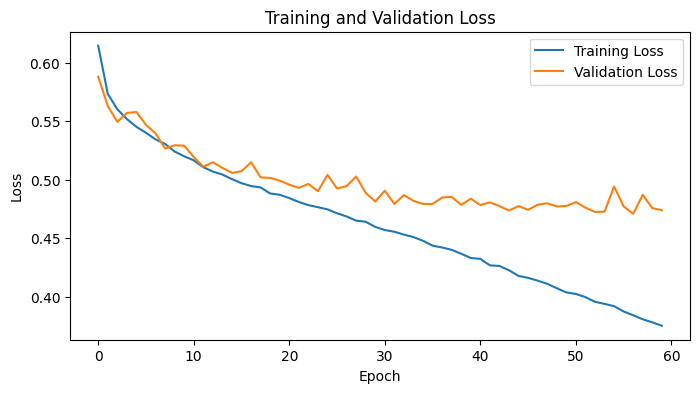

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(train_losses[:60], label='Training Loss')
plt.plot(val_losses[:60], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

In [43]:
save_path = '/content/drive/MyDrive/classification_model.pth'

In [44]:
from sklearn.metrics import (
    precision_recall_curve,
    roc_curve,
    auc,
    confusion_matrix)

model.load_state_dict(torch.load(save_path,weights_only=True))
model.eval()
total_test_preds = []
total_test_labels = []
test_loss = 0

with torch.no_grad():
    for pep_ids, mhc_ids, scores in test_loader:
        pep_ids, mhc_ids, scores = pep_ids.to(device), mhc_ids.to(device), scores.to(device)
        outputs = model(pep_ids, mhc_ids).squeeze()
        loss = criterion(outputs, scores)
        test_loss += loss.item()
        total_test_preds.append(torch.sigmoid(outputs).cpu())
        total_test_labels.append(scores.cpu())

test_loss /= len(test_loader)
total_test_preds = torch.cat(total_test_preds).numpy()
total_test_labels = torch.cat(total_test_labels).numpy()
threshold = 0.4256
binary_preds = (total_test_preds >= threshold).astype(int)
test_auroc = roc_auc_score(total_test_labels, total_test_preds)
test_f1 = f1_score(total_test_labels, binary_preds)
test_precision = precision_score(total_test_labels, binary_preds)
test_recall = recall_score(total_test_labels, binary_preds)
print(f"Test Loss: {test_loss:.4f}, AUROC: {test_auroc:.4f}, F1: {test_f1:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")


Test Loss: 0.4691, AUROC: 0.8700, F1: 0.7567, Precision: 0.7140, Recall: 0.8048


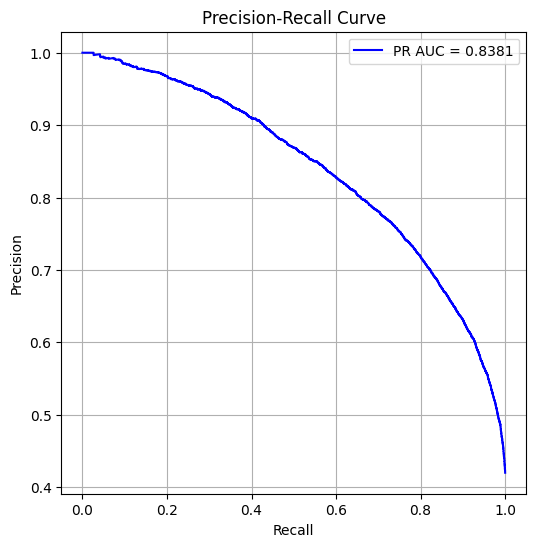

In [ ]:
precision, recall, _ = precision_recall_curve(total_test_labels, total_test_preds)
pr_auc = auc(recall, precision)


plt.figure(figsize=(6, 6))
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.4f}', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid()
plt.show()

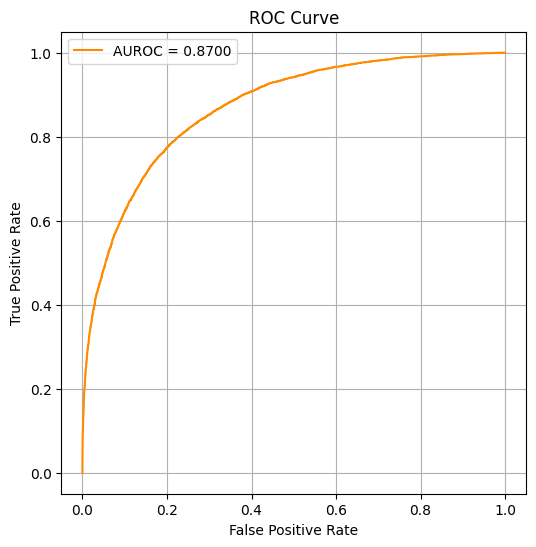

In [ ]:
fpr, tpr, _ = roc_curve(total_test_labels, total_test_preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'AUROC = {roc_auc:.4f}', color='darkorange')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.grid()
plt.show()

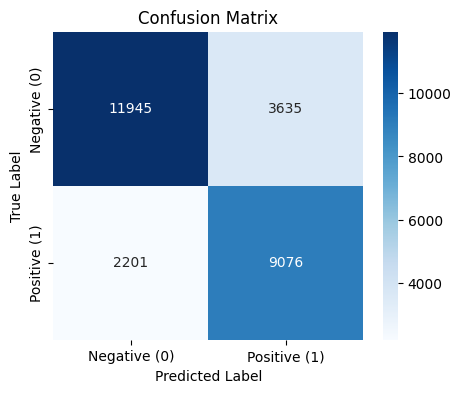

In [ ]:
cm = confusion_matrix(total_test_labels, binary_preds)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative (0)', 'Positive (1)'], yticklabels=['Negative (0)', 'Positive (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

K-Fold Cross Val

In [30]:
model_dim = 320
num_heads = 4
num_layers = 4
dropout = 0.2
ffdim = 512
model = SequenceModel(model_dim, num_heads, num_layers,ffdim,dropout=dropout).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001 ,weight_decay=4.691210368734568e-05)
epochs = 200

In [14]:
X = torch.stack((pep_embeddings,mhc_embeddings),dim=1)
y = torch.tensor(scoredf.values,dtype=torch.float32)

In [15]:
X.shape

torch.Size([134281, 2, 320])

In [16]:
y.shape

torch.Size([134281])

In [17]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [18]:
batch_size =  256

In [31]:
from torch.utils.data import Subset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
import torch
import numpy as np
import os

k_folds = 5 #num of folds
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

save_dir = "/content/drive/MyDrive"
os.makedirs(save_dir, exist_ok=True)

for fold, (train_idx, val_idx) in enumerate(kf.split(range(len(X_train)))):
    print(f"\n========== Starting Fold {fold + 1}/{k_folds} ==========")

    train_dataset = TensorDataset(X_train[train_idx, 0], X_train[train_idx, 1], y_train[train_idx])
    val_dataset = TensorDataset(X_train[val_idx, 0], X_train[val_idx, 1], y_train[val_idx])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    #model init
    model = SequenceModel(model_dim,num_heads,num_layers,ffdim)
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=4.691210368734568e-05)
    criterion = torch.nn.BCEWithLogitsLoss()

    #early stop params
    best_val_auroc = 0
    patience_counter = 0
    patience = 10
    threshold = 0.4256
    save_path = os.path.join(save_dir, f"best_model_fold_{fold + 1}.pth")

    for epoch in range(epochs):
        #train loop
        model.train()
        train_loss = 0
        total_train_preds, total_train_labels = [], []

        for pep_ids, mhc_ids, scores in train_loader:
            pep_ids, mhc_ids, scores = pep_ids.to(device), mhc_ids.to(device), scores.to(device)
            optimizer.zero_grad()
            outputs = model(pep_ids, mhc_ids).squeeze()
            loss = criterion(outputs, scores)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            total_train_preds.append(torch.sigmoid(outputs).detach().cpu())
            total_train_labels.append(scores.detach().cpu())

        train_loss /= len(train_loader)
        total_train_preds = torch.cat(total_train_preds).numpy()
        total_train_labels = torch.cat(total_train_labels).numpy()
        train_auroc = roc_auc_score(total_train_labels, total_train_preds)
        train_f1 = f1_score(total_train_labels, total_train_preds > threshold, zero_division=0)
        train_precision = precision_score(total_train_labels, total_train_preds > threshold, zero_division=0)
        train_recall = recall_score(total_train_labels, total_train_preds > threshold, zero_division=0)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, AUROC: {train_auroc:.4f}, F1: {train_f1:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}")

        #val loop
        model.eval()
        val_loss = 0
        total_val_preds, total_val_labels = [], []

        with torch.no_grad():
            for pep_ids, mhc_ids, scores in val_loader:
                pep_ids, mhc_ids, scores = pep_ids.to(device), mhc_ids.to(device), scores.to(device)
                outputs = model(pep_ids, mhc_ids).squeeze()
                loss = criterion(outputs, scores)
                val_loss += loss.item()
                total_val_preds.append(torch.sigmoid(outputs).cpu())
                total_val_labels.append(scores.cpu())

        val_loss /= len(val_loader)
        total_val_preds = torch.cat(total_val_preds).numpy()
        total_val_labels = torch.cat(total_val_labels).numpy()
        val_auroc = roc_auc_score(total_val_labels, total_val_preds)
        val_f1 = f1_score(total_val_labels, total_val_preds > threshold)
        val_precision = precision_score(total_val_labels, total_val_preds > threshold)
        val_recall = recall_score(total_val_labels, total_val_preds > threshold)

        print(f"Epoch {epoch+1}, Val Loss: {val_loss:.4f}, AUROC: {val_auroc:.4f}, F1: {val_f1:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}")

        #earlystop
        if val_auroc > best_val_auroc:
            best_val_auroc = val_auroc
            patience_counter = 0
            torch.save(model.state_dict(), save_path)
            print(f"Best model saved for Fold {fold+1} with AUROC: {best_val_auroc:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}. Best Val AUROC: {best_val_auroc:.4f}")
                break

    print(f"========== Completed Fold {fold + 1}/{k_folds} ==========")


========== Starting Fold 1/5 ==========
Epoch 1, Train Loss: 0.6026, AUROC: 0.7176, F1: 0.6075, Precision: 0.5770, Recall: 0.6414
Epoch 1, Val Loss: 0.5651, AUROC: 0.7645, F1: 0.6434, Precision: 0.6325, Recall: 0.6547
Best model saved for Fold 1 with AUROC: 0.7645
Epoch 2, Train Loss: 0.5596, AUROC: 0.7694, F1: 0.6478, Precision: 0.6315, Recall: 0.6650
Epoch 2, Val Loss: 0.5494, AUROC: 0.7826, F1: 0.6596, Precision: 0.6545, Recall: 0.6648
Best model saved for Fold 1 with AUROC: 0.7826
Epoch 3, Train Loss: 0.5453, AUROC: 0.7837, F1: 0.6622, Precision: 0.6453, Recall: 0.6800
Epoch 3, Val Loss: 0.5416, AUROC: 0.7883, F1: 0.6751, Precision: 0.6437, Recall: 0.7098
Best model saved for Fold 1 with AUROC: 0.7883
Epoch 4, Train Loss: 0.5362, AUROC: 0.7923, F1: 0.6701, Precision: 0.6516, Recall: 0.6897
Epoch 4, Val Loss: 0.5344, AUROC: 0.7978, F1: 0.6751, Precision: 0.6672, Recall: 0.6832
Best model saved for Fold 1 with AUROC: 0.7978
Epoch 5, Train Loss: 0.5251, AUROC: 0.8027, F1: 0.6806, Pre

Test Metrics:
Loss: 0.4355, AUROC: 0.8857, F1: 0.7698, Precision: 0.7446, Recall: 0.7968


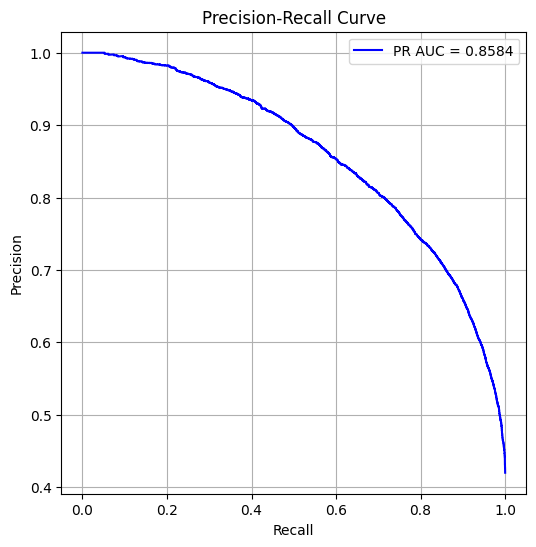

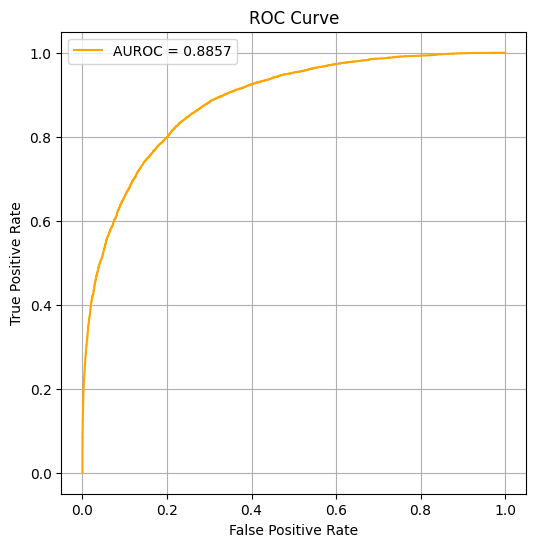

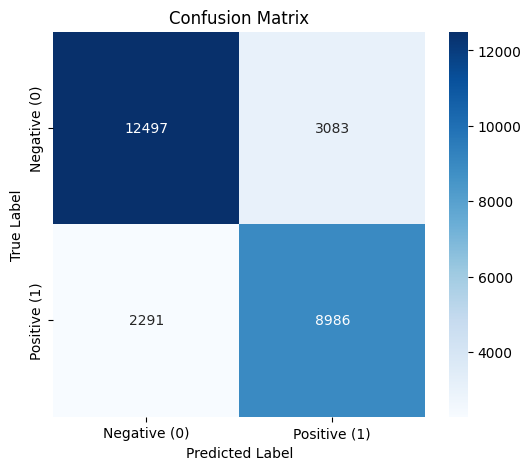

In [41]:
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, precision_recall_curve, roc_curve, confusion_matrix,auc
import seaborn as sns

test_dataset = TensorDataset(X_test[:, 0], X_test[:, 1], y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

save_dir = "/content/drive/MyDrive"
k_folds = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

models = []
for fold in range(k_folds):
    model = SequenceModel(model_dim, num_heads, num_layers, ffdim)
    model.to(device)
    model_path = os.path.join(save_dir, f"best_model_fold_{fold + 1}.pth")
    model.load_state_dict(torch.load(model_path,weights_only=True))
    model.eval()
    models.append(model)

total_preds = []
total_labels = []
total_loss = 0
criterion = nn.BCEWithLogitsLoss()
threshold = 0.4256
total_loss = 0
total_preds = []
total_labels = []

with torch.no_grad():
    for pep_ids, mhc_ids, scores in test_loader:
        pep_ids, mhc_ids, scores = pep_ids.to(device), mhc_ids.to(device), scores.to(device)

        outputs = torch.zeros_like(scores, dtype=torch.float32).to(device)
        for model in models:
            outputs += model(pep_ids, mhc_ids).squeeze()
        outputs /= len(models)

        loss = criterion(outputs, scores)
        total_loss += loss.item()

        probs = torch.sigmoid(outputs).cpu().numpy()

        total_preds.append(probs)
        total_labels.append(scores.cpu().numpy())

total_preds = np.concatenate(total_preds)
total_labels = np.concatenate(total_labels)


test_loss = total_loss / len(test_loader)
test_auroc = roc_auc_score(total_labels, total_preds)
test_f1 = f1_score(total_labels, total_preds > threshold)
test_precision = precision_score(total_labels, total_preds > threshold)
test_recall = recall_score(total_labels, total_preds > threshold)

print("Test Metrics:")
print(f"Loss: {test_loss:.4f}, AUROC: {test_auroc:.4f}, F1: {test_f1:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")

precision, recall, _ = precision_recall_curve(total_labels, total_preds)
plt.figure(figsize=(6,6))
test_pr_auc = auc(recall, precision)
plt.plot(recall, precision, color='blue', label=f'PR AUC = {test_pr_auc:.4f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

fpr, tpr, _ = roc_curve(total_labels, total_preds)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='orange', label=f'AUROC = {test_auroc:.4f}')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

conf_matrix = confusion_matrix(total_labels, total_preds > threshold)
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative (0)", "Positive (1)"], yticklabels=["Negative (0)", "Positive (1)"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
